# AI in Industry Project  
## Predicting Road Accident Risk (Kaggle Playground Series S5E10)

**Student:** *[Lukas Wijk & Brage Vik]*  
**Course:** AI in Industry  
**Goal:** Use machine learning to predict the likelihood of road accidents using the provided dataset.

### 📘 Overview
This notebook explores the *Playground Series S5E10* dataset from Kaggle, which simulates real-world accident risk prediction.  
We'll go through:
1. Data understanding  
2. Data preprocessing  
3. Model building  
4. Evaluation  
5. Discussion and conclusions


In [22]:
# Setup

import util
import matplotlib.pyplot as plt
import seaborn


figsize=(16, 5)


# A look at the data

(Some text describing the data, for example that it's synthetic)

In [23]:
# inport data
train = util.load_data("../data/train.csv")
test = util.load_data("../data/test.csv")

train.describe(include="all") # describe is a bit

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
count,517754.000000,517754,517754.000000,517754.000000,517754.000000,517754,517754,517754,517754,517754,517754,517754,517754.000000,517754.000000
unique,NaN,3,NaN,NaN,NaN,3,3,2,2,3,2,2,NaN,NaN
top,NaN,highway,NaN,NaN,NaN,dim,foggy,False,True,morning,True,False,NaN,NaN
freq,NaN,173672,NaN,NaN,NaN,183826,181463,259289,260045,173410,260688,260164,NaN,NaN
mean,258876.500000,NaN,2.491511,0.488719,46.112575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.187970,0.352377
std,149462.849975,NaN,1.120434,0.272563,15.788521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.895961,0.166417
min,0.000000,NaN,1.000000,0.000000,25.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,129438.250000,NaN,1.000000,0.260000,35.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.230000
50%,258876.500000,NaN,2.000000,0.510000,45.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.340000
75%,388314.750000,NaN,3.000000,0.710000,60.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,0.460000


The fourteen columns consits of a unique id for each road, 12 features and a target feature accident_risk. 
The accident_risk column is not present in the test set.

Some of the columns consists of non-numeric data types, such as road_type which can take on the values "highway", "rural" or "urban".
We transform these columns, by mapping each possible value to a unique integer.

In [24]:
util.cast_columns_to_categories(train)
util.cast_columns_to_categories(test)

### Correlation to target value

(Some text motivating our methods)

<Axes: >

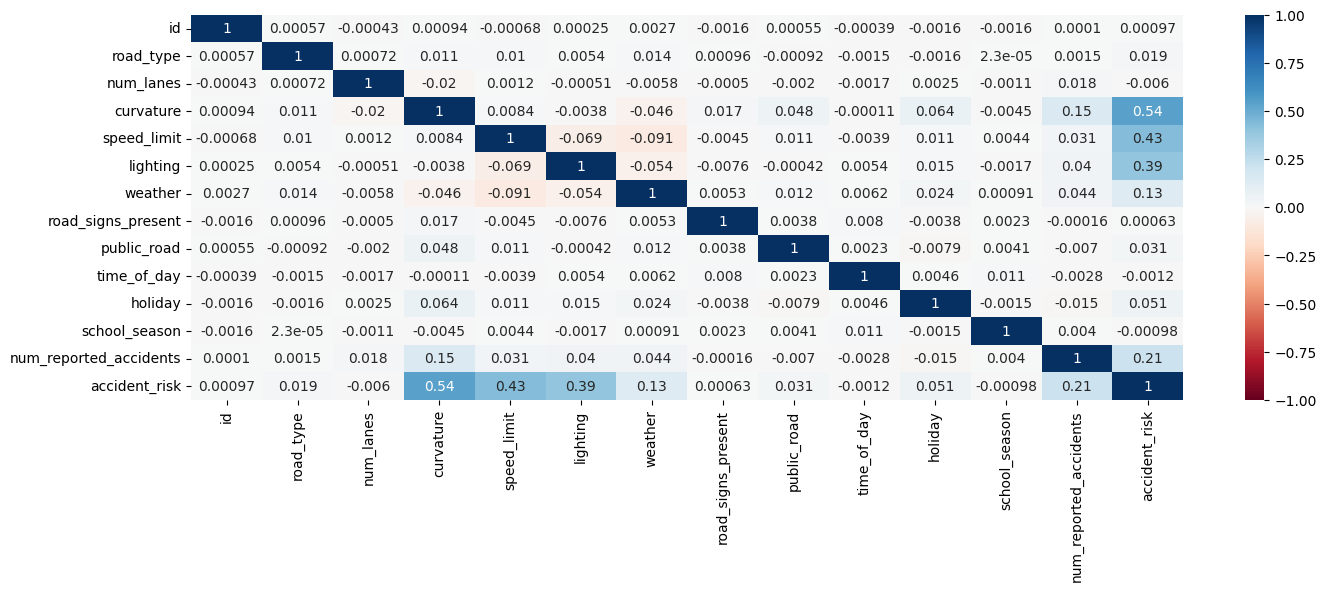

In [25]:
plt.figure(figsize = figsize)
seaborn.heatmap(train.corr(method="pearson"), annot=True,vmin=-1, vmax=1, cmap="RdBu")

** Lukas Branch starts here**